<font size = 14> one stage vs two stage </font>

* one stage就是直接通过一个主干网络预测类别和边界框，主要有yolo，ssd，retinanet等，优点是速度快，缺点是精度不高
* 而two stage是采用一个主干网络加一个辅助网络所以称之为2步预测，用辅助网络做一个简单的目标检测训练边界框，主要是R-CNN系列算法，优点是精度高，缺点是速度慢

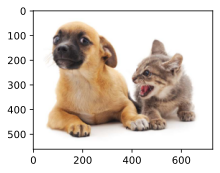

In [3]:
import matplotlib.pyplot as plt
import torch
from d2l import torch as d2l
%matplotlib inline
d2l.set_figsize()
img = d2l.plt.imread('catdog.jpg')
d2l.plt.imshow(img);

**<h4>在⽬标检测中，我们通常使⽤边界框（bounding box）来描述对象的空间位置</h4>**

**<h4>边界框是矩形的，由矩形左上⻆的以及右下⻆的x和y坐标决定</h4>**

**<h4>另⼀种常⽤的边界框表⽰⽅法是边界框中⼼的(x, y)轴坐标以及框的宽度和⾼度</h4>**

In [4]:
# 从矩形坐标转化到中心表示法
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，⾼度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    # stack函数的作用Concatenates a sequence of tensors along a new dimension.
    # All tensors need to be of the same size.
    return boxes

def box_center_to_corner(boxes):
    """从（中间，宽度，⾼度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [5]:
# 定义边界框测试下我们写的两个函数是否正确
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

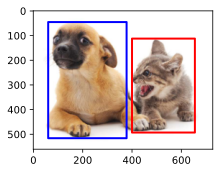

In [6]:
# 在图中画出boundingbox
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,⾼)
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
    fill=False, edgecolor=color, linewidth=2)

fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

In [7]:
import cv2 as cv
# 我用opencv的方式自己实现下画框的过程
img2 = cv.imread('catdog.jpg')
# 注意，opencv中的坐标点一定要是整数
cv.rectangle(img2, (60, 45), (378, 516), color=(255,0,0), thickness=3)
cv.rectangle(img2, (400, 112), (655, 493), color=(0,0,255), thickness=3)
cv.imshow("img", img2)
cv.waitKey()

ModuleNotFoundError: No module named 'cv2'

# 锚框
⽬标检测算法通常会在输⼊图像中采样⼤量的区域，然后判断这些区域中是否包含我们感兴趣的⽬标，并调
整区域边缘从而更准确地预测⽬标的真实边界框（ground-truth bounding box）。不同的模型使⽤的区域采
样⽅法可能不同。这⾥我们介绍其中的⼀种⽅法：它以每个像素为中⼼⽣成多个⼤小和宽⾼⽐（aspect ratio）
不同的边界框。这些边界框被称为锚框（anchor box）

In [9]:
torch.set_printoptions(2) # 精简打印精度

def multibox_prior(data, sizes, ratios):
    """⽣成以每个像素为中⼼具有不同形状的锚框。"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中⼼，需要设置偏移量。
    # 因为⼀个像素的的⾼为1且宽为1，我们选择偏移我们的中⼼0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height # Scaled steps in y axis
    steps_w = 1.0 / in_width # Scaled steps in x axis
    # 这个地方相当于做了归一化处理
    # ⽣成锚框的所有中⼼点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    # 举例而已meshgrid的作用“坐标化”
    # center_h： tensor([0.1250, 0.3750, 0.6250, 0.8750])
    # meshgrid后：tensor([
    #       [0.1250, 0.1250, 0.1250, 0.1250],
    #       [0.3750, 0.3750, 0.3750, 0.3750],
    #       [0.6250, 0.6250, 0.6250, 0.6250],
    #       [0.8750, 0.8750, 0.8750, 0.8750]])
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)   # 拉直
    # ⽣成“boxes_per_pixel”个⾼和宽，
    # 之后⽤于创建锚框的四⻆坐标(xmin, xmax, ymin, ymax)
    # w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width # Handle rectangular inputs
    # h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]), sizes[0] / torch.sqrt(ratio_tensor[1:])))
    w_0 = torch.cat((sizes[0] * torch.sqrt(in_height * ratio_tensor[:] / in_width),
                     size_tensor[1:] * torch.sqrt(in_height * ratio_tensor[0] / in_width)))
    h_0 = torch.cat((sizes[0] * torch.sqrt(in_width / ratio_tensor[:] / in_height), 
                     size_tensor[1:] * torch.sqrt(in_width / ratio_tensor[0] / in_height)))
    # 除以2来获得半⾼和半宽
    anchor_manipulations = torch.stack((-w_0, -h_0, w_0, h_0)).T.repeat(in_height * in_width, 1) / 2
    # 每个中⼼点都将有“boxes_per_pixel”个锚框，
    # 所以⽣成含所有锚框中⼼的⽹格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

img = d2l.plt.imread('catdog.jpg')
h, w = img.shape[:2]
print(h, w)
X = torch.rand(size=(1, 3, h, w))   # (batch_size, channel, h, w)
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
# 生成了2042040个锚框
boxes = Y.reshape(h, w, 5, 4)

561 728


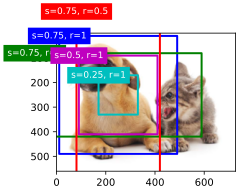

In [13]:
# 定义显示锚框的函数
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显⽰所有锚框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center', 
                      ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))
# 变量boxes中x轴和y轴的坐标值已分别除以图像的宽度和⾼度。绘制锚框时，
# 我们需要恢复它们原始的坐标值。因此，我们在下⾯定义了变量bbox_scale

bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.75, r=2', 's=0.75, r=0.5', 's=0.5, r=1',
             's=0.25, r=1'])

200.0 200.0 530.3300858899106 265.16504294495536
200.0 200.0 375.0 375.0
200.0 200.0 265.1650429449553 530.3300858899107
200.0 200.0 424.2640687119285 212.13203435596427
200.0 200.0 300.0 300.0
200.0 200.0 212.13203435596424 424.26406871192853


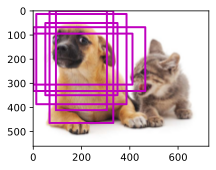

In [20]:
## 不同的算法模型其实生成锚框的算法都不太一样，比如下面写一个简单的生成算法

import math
def draw_anchor_box(center, length, scales, ratios, img_height, img_width):
    """
    以center为中心, 产生一系列锚框
    其中length指定了一个基准的长度
    scales是包含多种尺寸比例的list
    ratios是包含多种长宽比的list
    img_height和img_width是图片的尺寸, 生成的锚框范围不能超出图片尺寸之外
    """
    bboxes = []
    for scale in scales:
        for ratio in ratios:
            h = length*scale*math.sqrt(ratio)
            w = length*scale/math.sqrt(ratio) 
            x1 = max(center[0] - w/2., 0.)
            y1 = max(center[1] - h/2., 0.)
            x2 = min(center[0] + w/2. - 1.0, img_width - 1.0)
            y2 = min(center[1] + h/2. - 1.0, img_height - 1.0)
            print(center[0], center[1], w, h)
            bboxes.append([x1, y1, x2, y2])

    fig = d2l.plt.imshow(img)
    for bbox in bboxes:
        temp = bbox_to_rect(bbox=bbox, color='m')
        fig.axes.add_patch(temp)
        # draw_rectangle(currentAxis, bbox, edgecolor = 'b')

img_height = img.shape[0]
img_width = img.shape[1] 
# 绘制锚框
draw_anchor_box([200., 200.], 150., [2.5, 2], [0.5, 1.0, 2.0], img_height, img_width)

# 交并比

In [22]:
## 交并比是一个数学上集合的概念，求两个区域相交面积与取并集面积的比值
## 在这里我们假设两个矩形框有相交的区域的话，设A:[xa1,ya1,xa2,ya2] B:[xb1,yb1,xb2,yb2]
## 则相交部分左上角坐标为：x1=max(xa1,xb1),  y1=max(ya1,yb1)
## 相交部分右下角坐标为：x2=min(xa2,xb2),   y2=min(ya2,yb2)
## 可以很容易计算得到相交区域的面积  intersection = max(x2−x1+1.0,0) * max(y2−y1+1.0,0)
## 至于并集的面积也很好计算，个人认为是俩个框的面积之和减掉相交面积是最简单的

# 需要注意的是当这里的锚框是全部存在一起一个矩阵时如何处理？
import numpy as np

# 计算IoU，矩形框的坐标形式为xyxy
def box_iou_xyxy(box1, box2):
    # 获取box1左上角和右下角的坐标
    x1min, y1min, x1max, y1max = box1[0], box1[1], box1[2], box1[3]
    # 计算box1的面积
    s1 = (y1max - y1min + 1.) * (x1max - x1min + 1.)
    # 获取box2左上角和右下角的坐标
    x2min, y2min, x2max, y2max = box2[0], box2[1], box2[2], box2[3]
    # 计算box2的面积
    s2 = (y2max - y2min + 1.) * (x2max - x2min + 1.)
    
    # 计算相交矩形框的坐标
    xmin = np.maximum(x1min, x2min)
    ymin = np.maximum(y1min, y2min)
    xmax = np.minimum(x1max, x2max)
    ymax = np.minimum(y1max, y2max)
    # 计算相交矩形行的高度、宽度、面积
    inter_h = np.maximum(ymax - ymin + 1., 0.)
    inter_w = np.maximum(xmax - xmin + 1., 0.)
    intersection = inter_h * inter_w
    # 计算相并面积
    union = s1 + s2 - intersection
    # 计算交并比
    iou = intersection / union
    return iou


bbox1 = [100., 100., 200., 200.]
bbox2 = [120., 120., 220., 220.]
iou = box_iou_xyxy(bbox1, bbox2)
print('IoU is {}'.format(iou)) 

import numpy as np

# 计算IoU，矩形框的坐标形式为xywh
def box_iou_xywh(box1, box2):
    x1min, y1min = box1[0] - box1[2]/2.0, box1[1] - box1[3]/2.0
    x1max, y1max = box1[0] + box1[2]/2.0, box1[1] + box1[3]/2.0
    s1 = box1[2] * box1[3]

    x2min, y2min = box2[0] - box2[2]/2.0, box2[1] - box2[3]/2.0
    x2max, y2max = box2[0] + box2[2]/2.0, box2[1] + box2[3]/2.0
    s2 = box2[2] * box2[3]

    xmin = np.maximum(x1min, x2min)
    ymin = np.maximum(y1min, y2min)
    xmax = np.minimum(x1max, x2max)
    ymax = np.minimum(y1max, y2max)
    inter_h = np.maximum(ymax - ymin, 0.)
    inter_w = np.maximum(xmax - xmin, 0.)
    intersection = inter_h * inter_w

    union = s1 + s2 - intersection
    iou = intersection / union
    return iou

bbox1 = [100., 100., 200., 200.]
bbox2 = [120., 120., 220., 220.]
iou = box_iou_xywh(bbox1, bbox2)
print('IoU is {}'.format(iou)) 

IoU is 0.47402644317607107
IoU is 0.6902485659655831
